#**Osservazioni sulle vendite annuali di prodotti dei settori Calcio, Pesca e Casual**



In [1]:
#https://github.com/TommasoStrada/Progetto-Data-Science-Lab

The XGBoost (eXtreme Gradient Boosting) is a popular and efficient open-source implementation of the gradient boosted trees algorithm. Gradient boosting is a supervised learning algorithm that attempts to accurately predict a target variable by combining an ensemble of estimates from a set of simpler and weaker models. The XGBoost algorithm performs well in machine learning competitions because of its robust handling of a variety of data types, relationships, distributions, and the variety of hyperparameters that you can fine-tune. You can use XGBoost for regression, classification (binary and multiclass), and ranking problems.

# **COSE DA SETTARE DOPO AVER COPIATO IL CODICE IN FUNZIONE DELLE DIVERSE GRANULARITA':**
- repo_alessandro_calcio --> nome aggregazione
- uso delle repo del team
- scommentare il cambio di tipo nella data: ds_calcio_annuale['year'] = pd.to_datetime(ds_calcio_annuale['year'])
- cambiare i nome delle variabili temporali in month, trimestre e week
- nomi features, legenda e titolo nei plot
- cosa vogliamo come altre misure di bonta delle predizioni
- sistemare asse y con valore delle vendite più leggibile rispetto alla notazione esponenziale
- Lista di params modificata che cambiamo dopo un primo giro di run per raccogliere i dati su cambiamenti di performance e i plot da inserire nel record per i confronti e le dimostrazioni di cura delle performance

In [2]:
#!pip install xgboost 1.6

In [3]:
import math
import pandas as pd
import seaborn as sns
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import xgboost

In [4]:
shift_annuale = 1        #anno precedente

porzione_test = 2        # 20% circa

In [5]:
repo_alessandro_calcio = "https://github.com/Alessandro-Fasani/DsLab/raw/main/calcio_annuale.csv"
repo_alessandro_pesca = "https://github.com/Alessandro-Fasani/DsLab/raw/main/pesca_annuale.csv"
repo_alessandro_casual = "https://github.com/Alessandro-Fasani/DsLab/raw/main/casual_annuale.csv"

repo_team_calcio = ""
repo_team_pesca = ""
repo_team_casual = ""

In [6]:
ds_calcio = pd.read_csv(repo_alessandro_calcio)
ds_pesca = pd.read_csv(repo_alessandro_pesca)
ds_casual = pd.read_csv(repo_alessandro_casual)


ds_calcio.tail(50)

,Unnamed: 0,year,revenue
0,0,2014,3365712.79
1,1,2015,4234959.81
2,2,2016,3876798.63
3,3,2017,4552611.48
4,4,2018,5435884.85
5,5,2019,8278321.97
6,6,2020,4764396.03
7,7,2021,3707615.13
8,8,2022,800860.61


In [7]:
#ds_calcio['year'] = pd.to_datetime(ds_calcio['year'])
#ds_pesca['year'] = pd.to_datetime(ds_pesca['year'])
#ds_casual['year'] = pd.to_datetime(ds_casual['year'])
ds_calcio.dtypes

Unnamed: 0      int64
year            int64
revenue       float64
dtype: object

In [8]:
print("xgboost versione numero: ", xgboost.__version__)

xgboost versione numero:  0.90


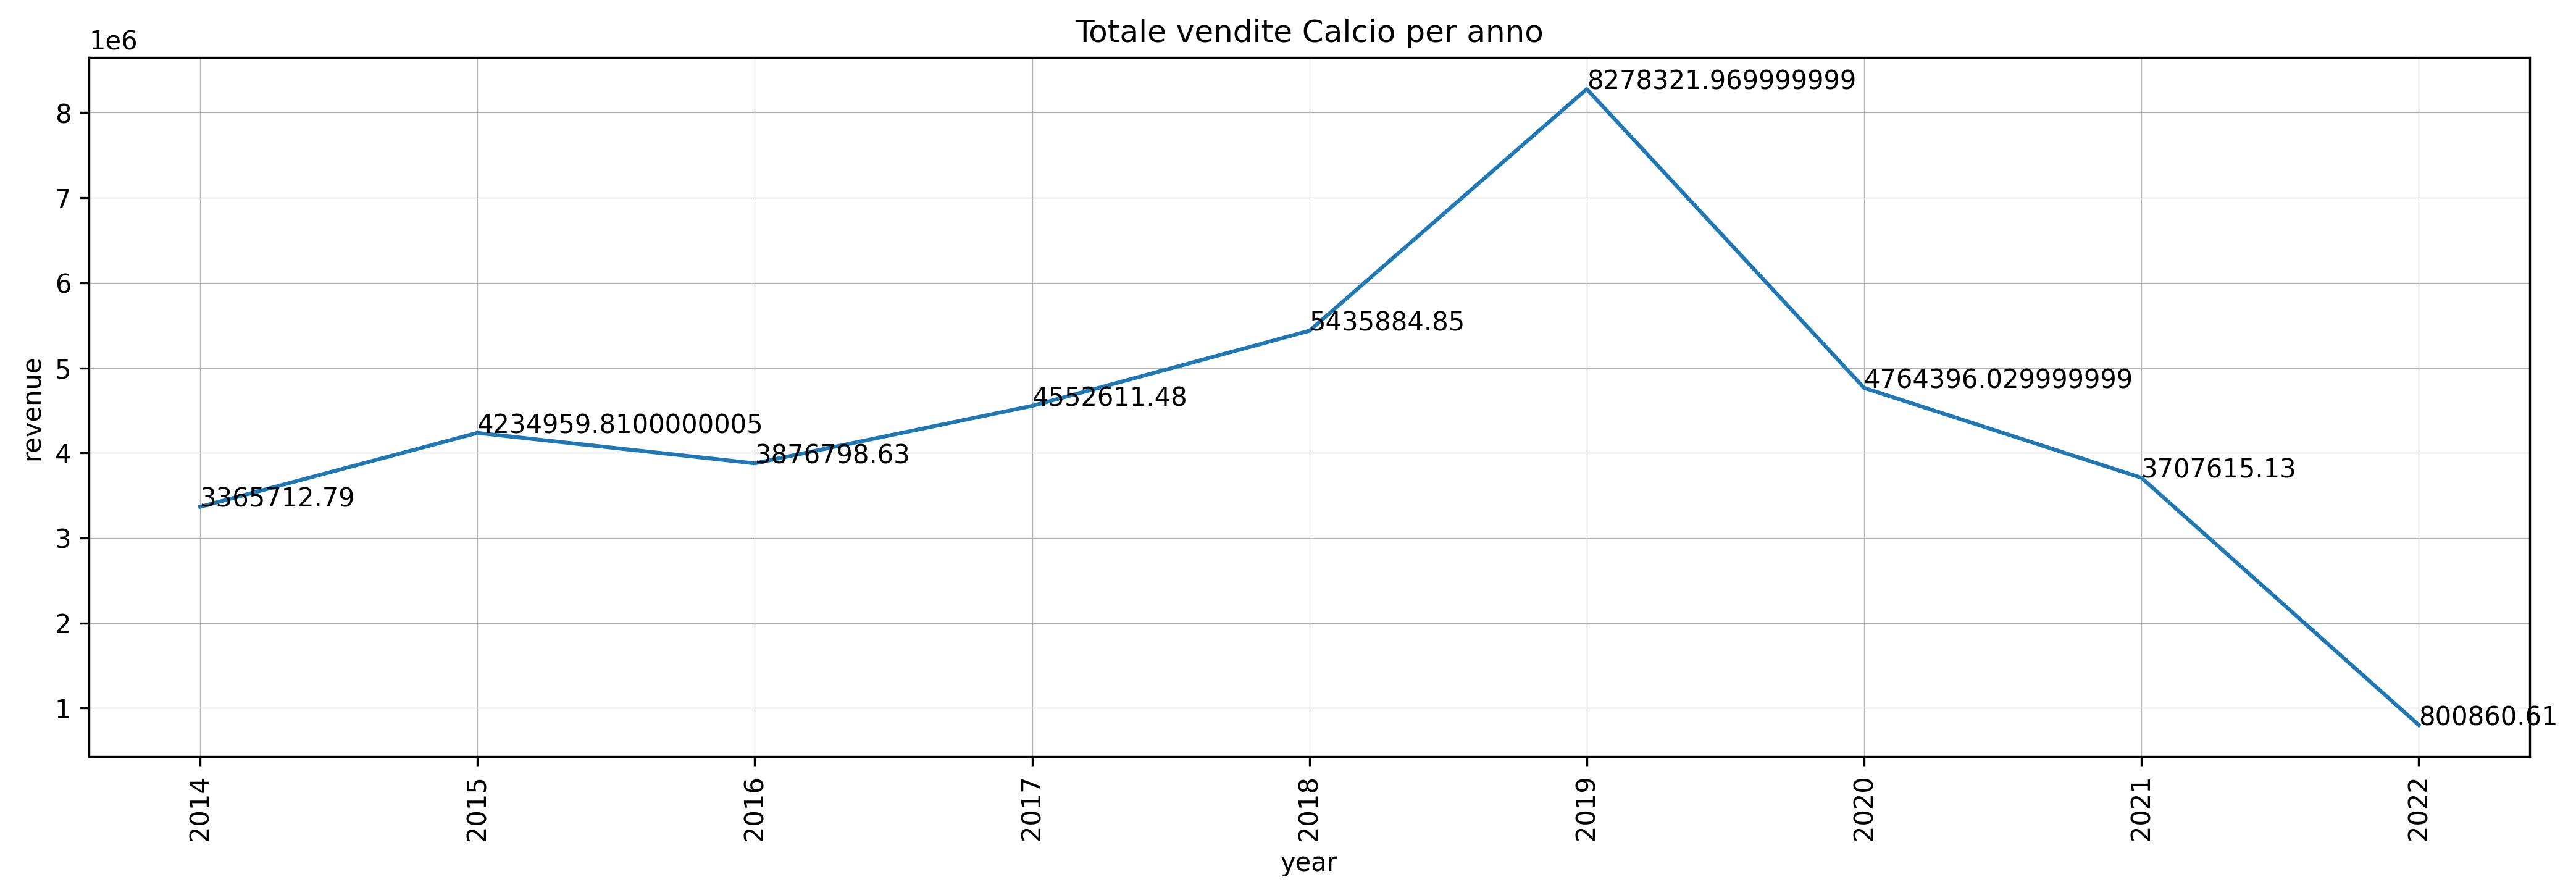

In [9]:
plt.rcParams.update({'figure.figsize': (17, 5), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=ds_calcio, x='year',  y='revenue')
plt.grid(linestyle='-', linewidth=0.3)
x = ds_calcio['year']  
y = ds_calcio['revenue']
for i,j in zip(x,y):
  plt.annotate(str(j),xy=(i,j))
plt.title("Totale vendite Calcio per anno")
ax.tick_params(axis='x', rotation=90)

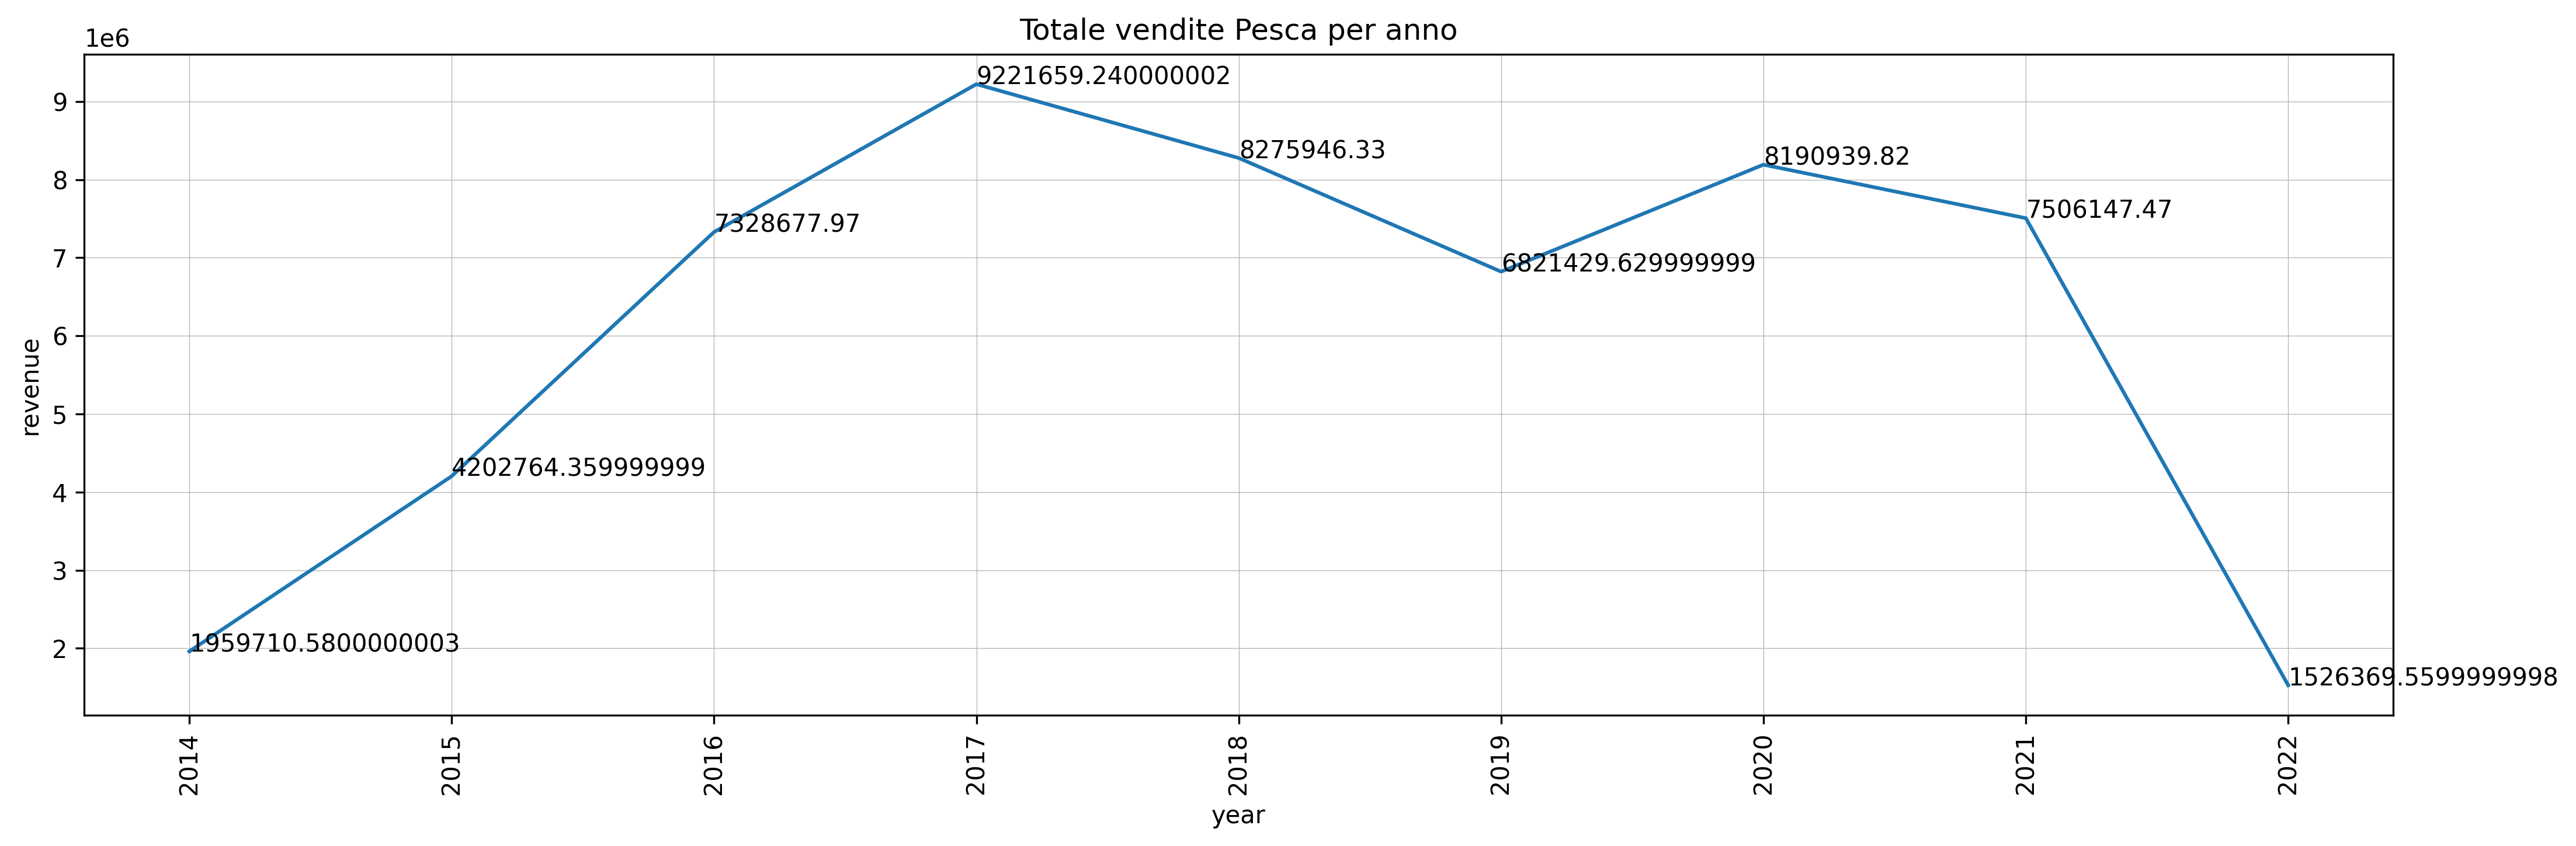

In [10]:
plt.rcParams.update({'figure.figsize': (17, 5), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=ds_pesca, x='year',  y='revenue')
plt.grid(linestyle='-', linewidth=0.3)
x = ds_pesca['year']  
y = ds_pesca['revenue']
for i,j in zip(x,y):
  plt.annotate(str(j),xy=(i,j))
plt.title("Totale vendite Pesca per anno")
ax.tick_params(axis='x', rotation=90)

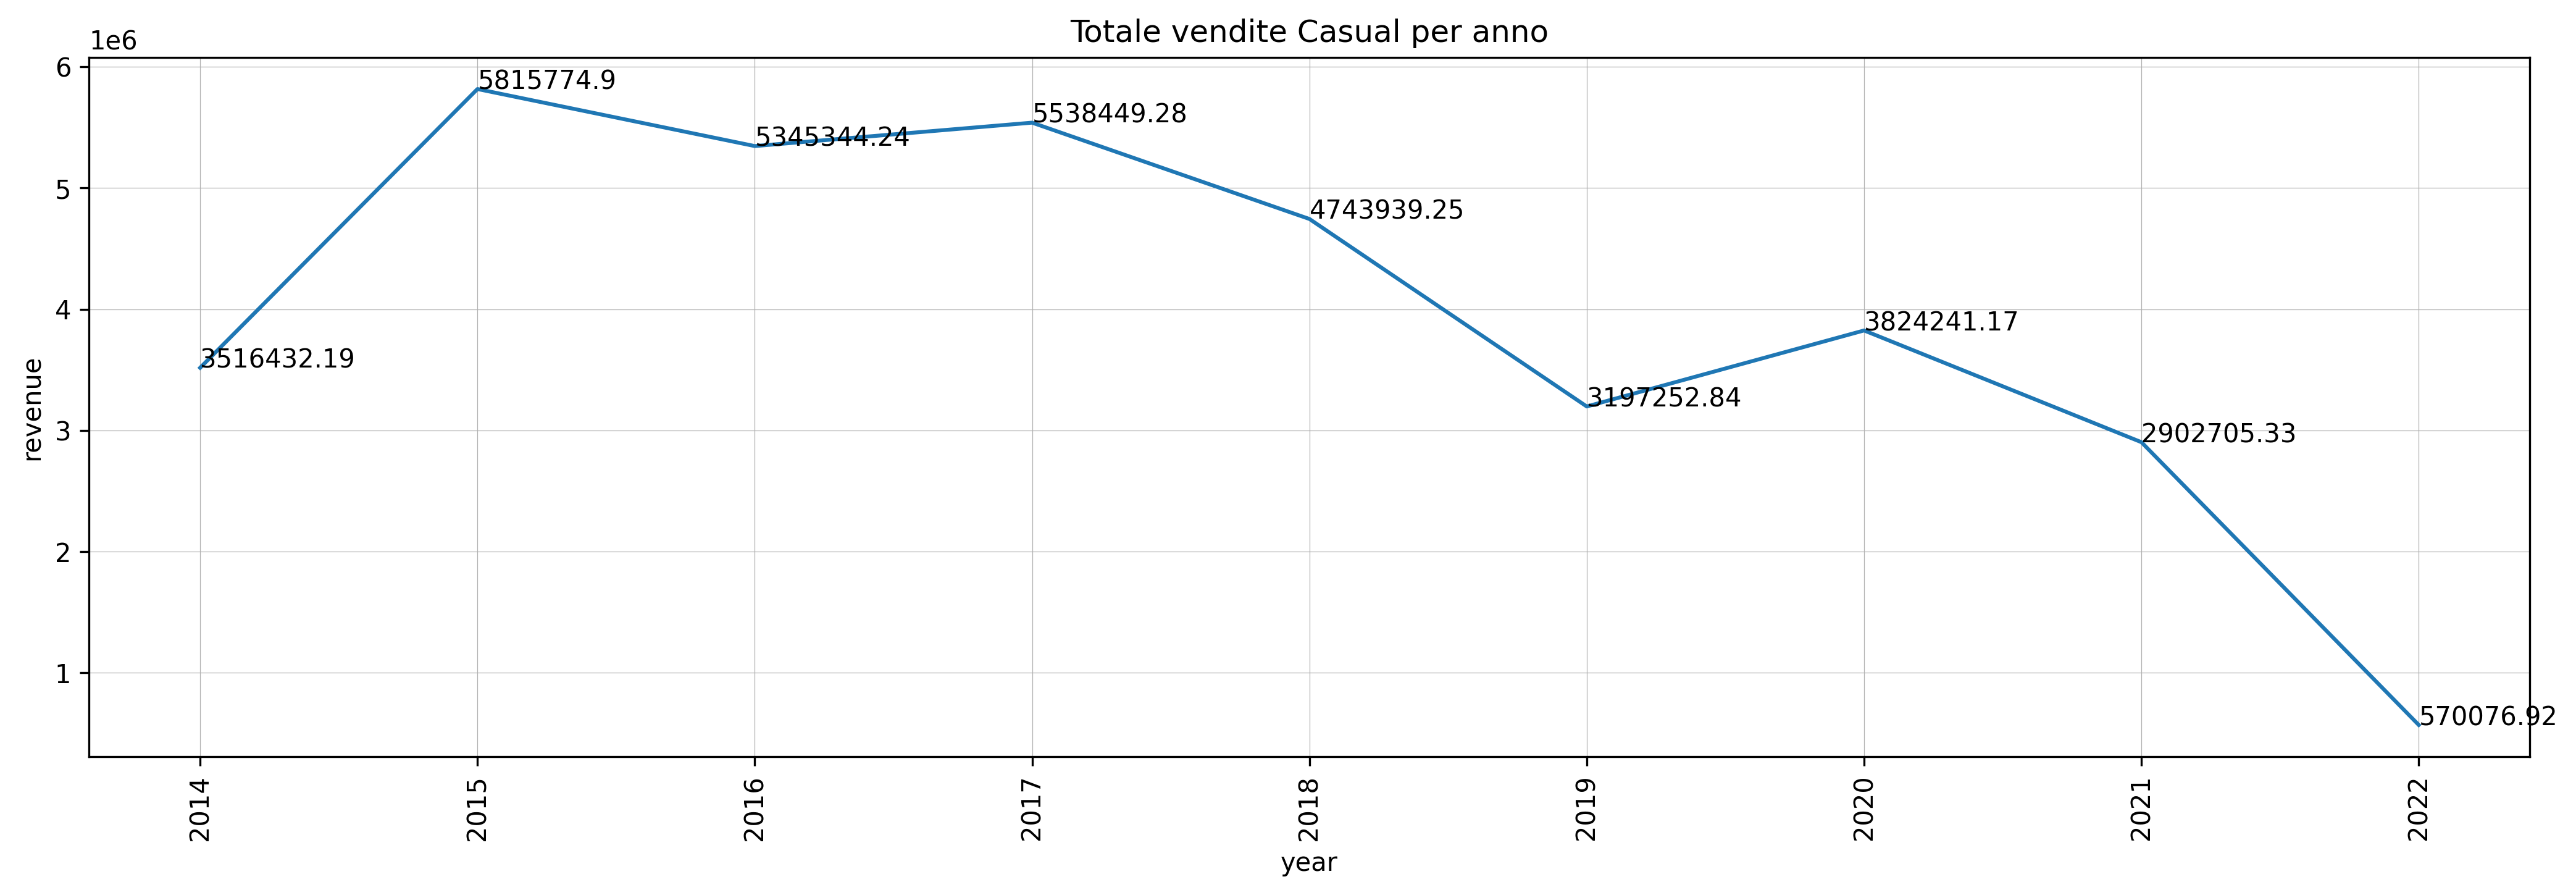

In [11]:
plt.rcParams.update({'figure.figsize': (17, 5), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=ds_casual, x='year',  y='revenue')
x = ds_casual['year']  
y = ds_casual['revenue']
for i,j in zip(x,y):
  plt.annotate(str(j),xy=(i,j))
plt.title("Totale vendite Casual per anno")
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

In [12]:
ds_calcio["totale_periodo_prec"] = ds_calcio["revenue"].shift(+shift_annuale)
ds_pesca["totale_periodo_prec"] = ds_pesca["revenue"].shift(+shift_annuale)
ds_casual["totale_periodo_prec"] = ds_casual["revenue"].shift(+shift_annuale)

#DECIDIAMO DI ELIMINARE L'ANNO 2022 DALLA PREVISIONE IN QUANTO INCOMPLETO E PROPORZIONALMENTE PICCOLO RISPETTO AI PRECEDENTI ANNI

ds_calcio= ds_calcio.iloc[:(len(ds_calcio)-1)].dropna()    #.iloc[:(len(ds_calcio)-1)]
ds_pesca= ds_pesca.iloc[:(len(ds_pesca)-1)].dropna()    #.iloc[:(len(ds_pesca)-1)]
ds_casual= ds_casual.iloc[:(len(ds_casual)-1)].dropna()    #.iloc[:(len(ds_casual)-1)]

ds_calcio

,Unnamed: 0,year,revenue,totale_periodo_prec
1,1,2015,4234959.81,3365712.79
2,2,2016,3876798.63,4234959.81
3,3,2017,4552611.48,3876798.63
4,4,2018,5435884.85,4552611.48
5,5,2019,8278321.97,5435884.85
6,6,2020,4764396.03,8278321.97
7,7,2021,3707615.13,4764396.03


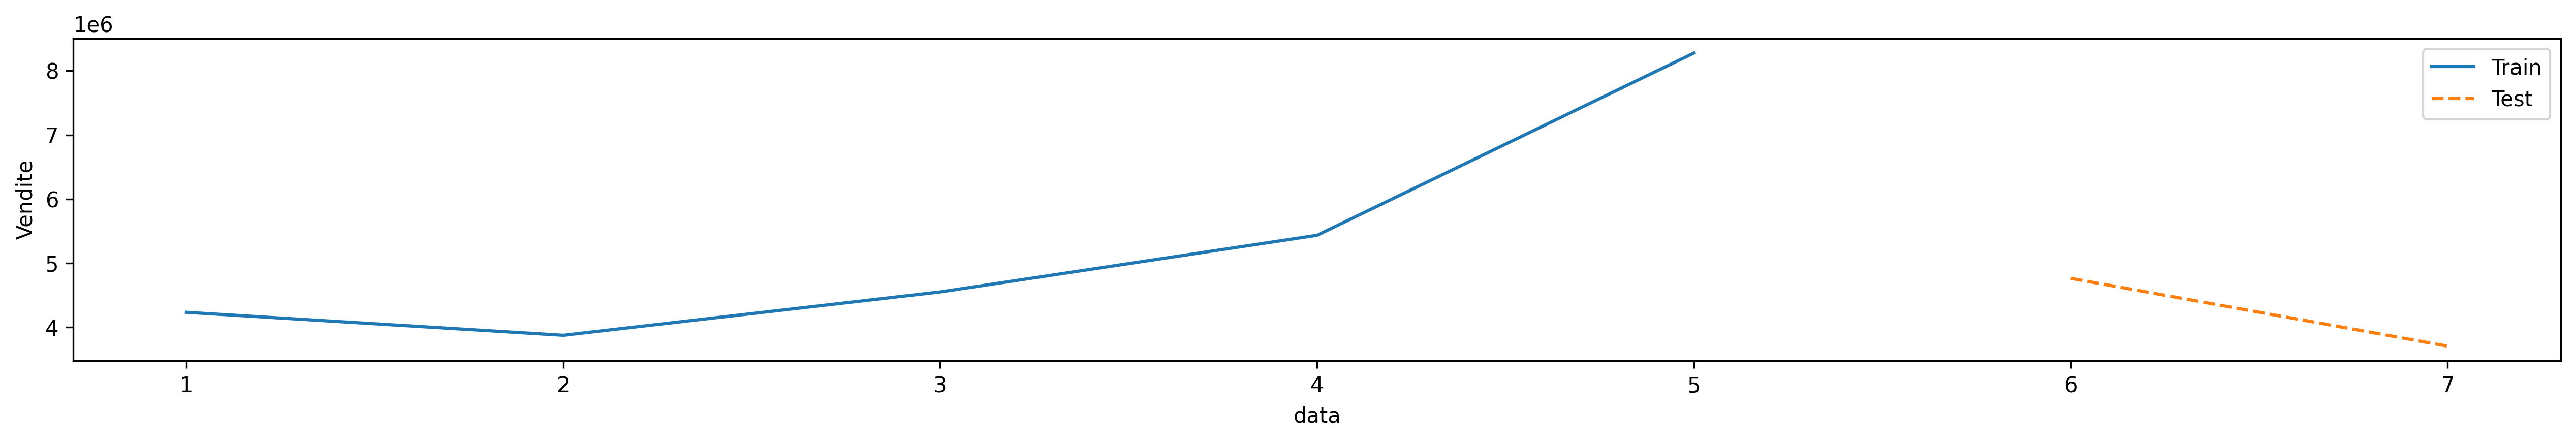

In [13]:
#LIST INPUT, divisione tra parte train e parte dedicata al test
x_calcio = ds_calcio[['totale_periodo_prec']]
x_pesca = ds_pesca[['totale_periodo_prec']]
x_casual = ds_casual[['totale_periodo_prec']]

x_calcio_to_train = x_calcio.iloc[:(len(x_calcio)-porzione_test)]
x_pesca_to_train = x_pesca.iloc[:(len(x_pesca)-porzione_test)]
x_casual_to_train = x_casual.iloc[:(len(x_casual)-porzione_test)]

x_calcio_to_test = x_calcio.iloc[(len(x_calcio)-porzione_test):]
x_pesca_to_test = x_pesca.iloc[(len(x_pesca)-porzione_test):]
x_casual_to_test = x_casual.iloc[(len(x_casual)-porzione_test):]


#LIST OUTPUT, divisione tra parte train e parte dedicata al test
y_calcio = ds_calcio[['revenue']]
y_pesca = ds_pesca[['revenue']]
y_casual = ds_casual[['revenue']]

y_calcio_to_train = y_calcio.iloc[:(len(y_calcio)-porzione_test)]
y_pesca_to_train = y_pesca.iloc[:(len(y_pesca)-porzione_test)]
y_casual_to_train = y_casual.iloc[:(len(y_casual)-porzione_test)]

y_calcio_to_test = y_calcio.iloc[(len(y_calcio)-porzione_test):]
y_pesca_to_test = y_pesca.iloc[(len(y_pesca)-porzione_test):]
y_casual_to_test = y_casual.iloc[(len(y_casual)-porzione_test):]

fig, ax = plt.subplots(figsize=(17, 3))
ax.plot(y_calcio_to_train, ls='-', label='Train')
ax.plot(y_calcio_to_test, ls='--', label='Test')
ax.set_xlabel('data')
ax.set_ylabel('Vendite')

ax.legend(loc='best')
plt.tight_layout()
plt.show()

In [14]:
estimator_calcio = XGBRegressor(objective='reg:squarederror', n_estimators=180, learning_rate=0.01)
estimator_pesca = XGBRegressor(objective='reg:squarederror', n_estimators=420, learning_rate=0.01)
estimator_casual = XGBRegressor(objective='reg:squarederror', n_estimators=150, learning_rate=0.01)

estimator_calcio.fit(x_calcio_to_train, y_calcio_to_train,
              eval_set=[(x_calcio_to_train, y_calcio_to_train), (x_calcio_to_test, y_calcio_to_test)],
              eval_metric='mae')

estimator_pesca.fit(x_pesca_to_train, y_pesca_to_train,
              eval_set=[(x_pesca_to_train, y_pesca_to_train), (x_pesca_to_test, y_pesca_to_test)],
              eval_metric='mae')

estimator_casual.fit(x_casual_to_train, y_casual_to_train,
              eval_set=[(x_casual_to_train, y_casual_to_train), (x_casual_to_test, y_casual_to_test)],
              eval_metric='mae')

[0]	validation_0-mae:5.23175e+06	validation_1-mae:4.19204e+06
[1]	validation_0-mae:5.18815e+06	validation_1-mae:4.14844e+06
[2]	validation_0-mae:5.14492e+06	validation_1-mae:4.10521e+06
[3]	validation_0-mae:5.10204e+06	validation_1-mae:4.06233e+06
[4]	validation_0-mae:5.05953e+06	validation_1-mae:4.01982e+06
[5]	validation_0-mae:5.01736e+06	validation_1-mae:3.97765e+06
[6]	validation_0-mae:4.97555e+06	validation_1-mae:3.93584e+06
[7]	validation_0-mae:4.93409e+06	validation_1-mae:3.89438e+06
[8]	validation_0-mae:4.89297e+06	validation_1-mae:3.85326e+06
[9]	validation_0-mae:4.8522e+06	validation_1-mae:3.81249e+06
[10]	validation_0-mae:4.81176e+06	validation_1-mae:3.77205e+06
[11]	validation_0-mae:4.77166e+06	validation_1-mae:3.73195e+06
[12]	validation_0-mae:4.7319e+06	validation_1-mae:3.69219e+06
[13]	validation_0-mae:4.69247e+06	validation_1-mae:3.65276e+06
[14]	validation_0-mae:4.65336e+06	validation_1-mae:3.61365e+06
[15]	validation_0-mae:4.61459e+06	validation_1-mae:3.57488e+06
[16]

XGBRegressor(learning_rate=0.01, n_estimators=150, objective='reg:squarederror')

In [15]:
predictions_calcio = estimator_calcio.predict(x_calcio_to_test)
predictions_pesca = estimator_pesca.predict(x_pesca_to_test)
predictions_casual = estimator_casual.predict(x_casual_to_test)

#ds_calcio_annuale = ds_calcio_annuale.reset_index().drop('index', axis=1)  #non posso usarli perchè me li aggiunge all'inizio del dataset
#ds_calcio_annuale['predictions'] = pd.Series(predictions)

#plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
#fig, ax = plt.subplots()
#sns.lineplot(data=ds_calcio_annuale, x= "year", y='revenue')
#sns.lineplot(data=ds_calcio_annuale, x='year', y='predictions', palette= "red")
#plt.grid(linestyle='-', linewidth=0.3)
#ax.tick_params(axis='x', rotation=90)

In [16]:
calcio_evalutation_ds = ds_calcio[(len(ds_calcio)-porzione_test):]   
calcio_evalutation_ds = calcio_evalutation_ds.reset_index().drop('index', axis=1)
calcio_evalutation_ds['predictions'] = pd.Series(predictions_calcio)
calcio_evalutation_ds

,Unnamed: 0,year,revenue,totale_periodo_prec,predictions
0,6,2020,4764396.03,8278321.97,4770730.0
1,7,2021,3707615.13,4764396.03,4320212.0


In [17]:
pesca_evalutation_ds = ds_pesca[(len(ds_pesca)-porzione_test):]  
pesca_evalutation_ds = pesca_evalutation_ds.reset_index().drop('index', axis=1)
pesca_evalutation_ds['predictions'] = pd.Series(predictions_pesca)
pesca_evalutation_ds

,Unnamed: 0,year,revenue,totale_periodo_prec,predictions
0,6,2020,8190939.82,6821429.63,8184357.5
1,7,2021,7506147.47,8190939.82,6865867.5


In [18]:
casual_evalutation_ds = ds_casual[(len(ds_casual)-porzione_test):]  
casual_evalutation_ds = casual_evalutation_ds.reset_index().drop('index', axis=1)
casual_evalutation_ds['predictions'] = pd.Series(predictions_casual)
casual_evalutation_ds

,Unnamed: 0,year,revenue,totale_periodo_prec,predictions
0,6,2020,3824241.17,3197252.84,3523587.75
1,7,2021,2902705.33,3824241.17,3523587.75


In [19]:
#TROVARE UN VALUTATORE DELLE PERFORMANCE DI FITTING ANALOGO PER L'XGBOOST
#print('Did the model fit?', pd.Series(predictions_calcio).is_fitted) 
#print('AIC', pd.Series(predictions).aic) 
#print(pesca_evalutation_ds.summary())


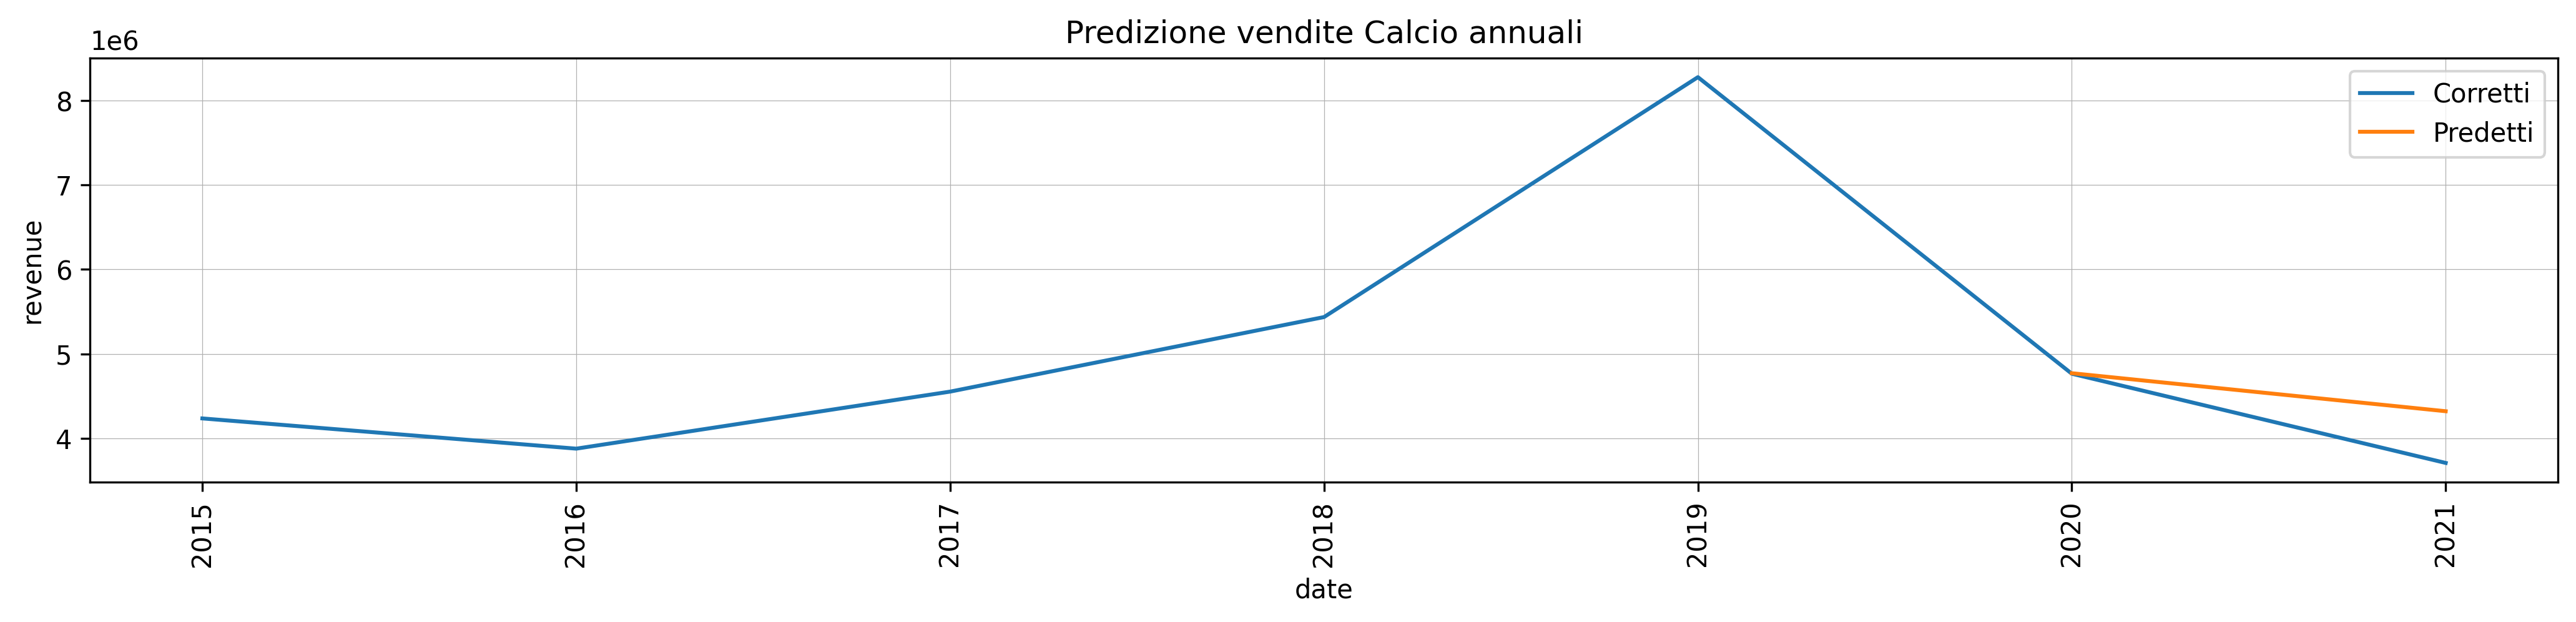

In [33]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=ds_calcio, x= "year", y='revenue', label= "Corretti" )     #_evalutation
sns.lineplot(data=calcio_evalutation_ds, x='year', y='predictions', palette= "red",  label= "Predetti")

#x = calcio_evalutation_ds['year']  
#y = calcio_evalutation_ds['predictions']
#for i,j in zip(x,y):
#  plt.annotate(str(j),xy=(i,j))
#
#y1 = calcio_evalutation_ds['revenue']
#for i,j in zip(x,y1):
#  plt.annotate(str(j),xy=(i,j))
#  calcio_evalutation_ds

plt.title("Predizione vendite Calcio annuali")
plt.xlabel ("date")

plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

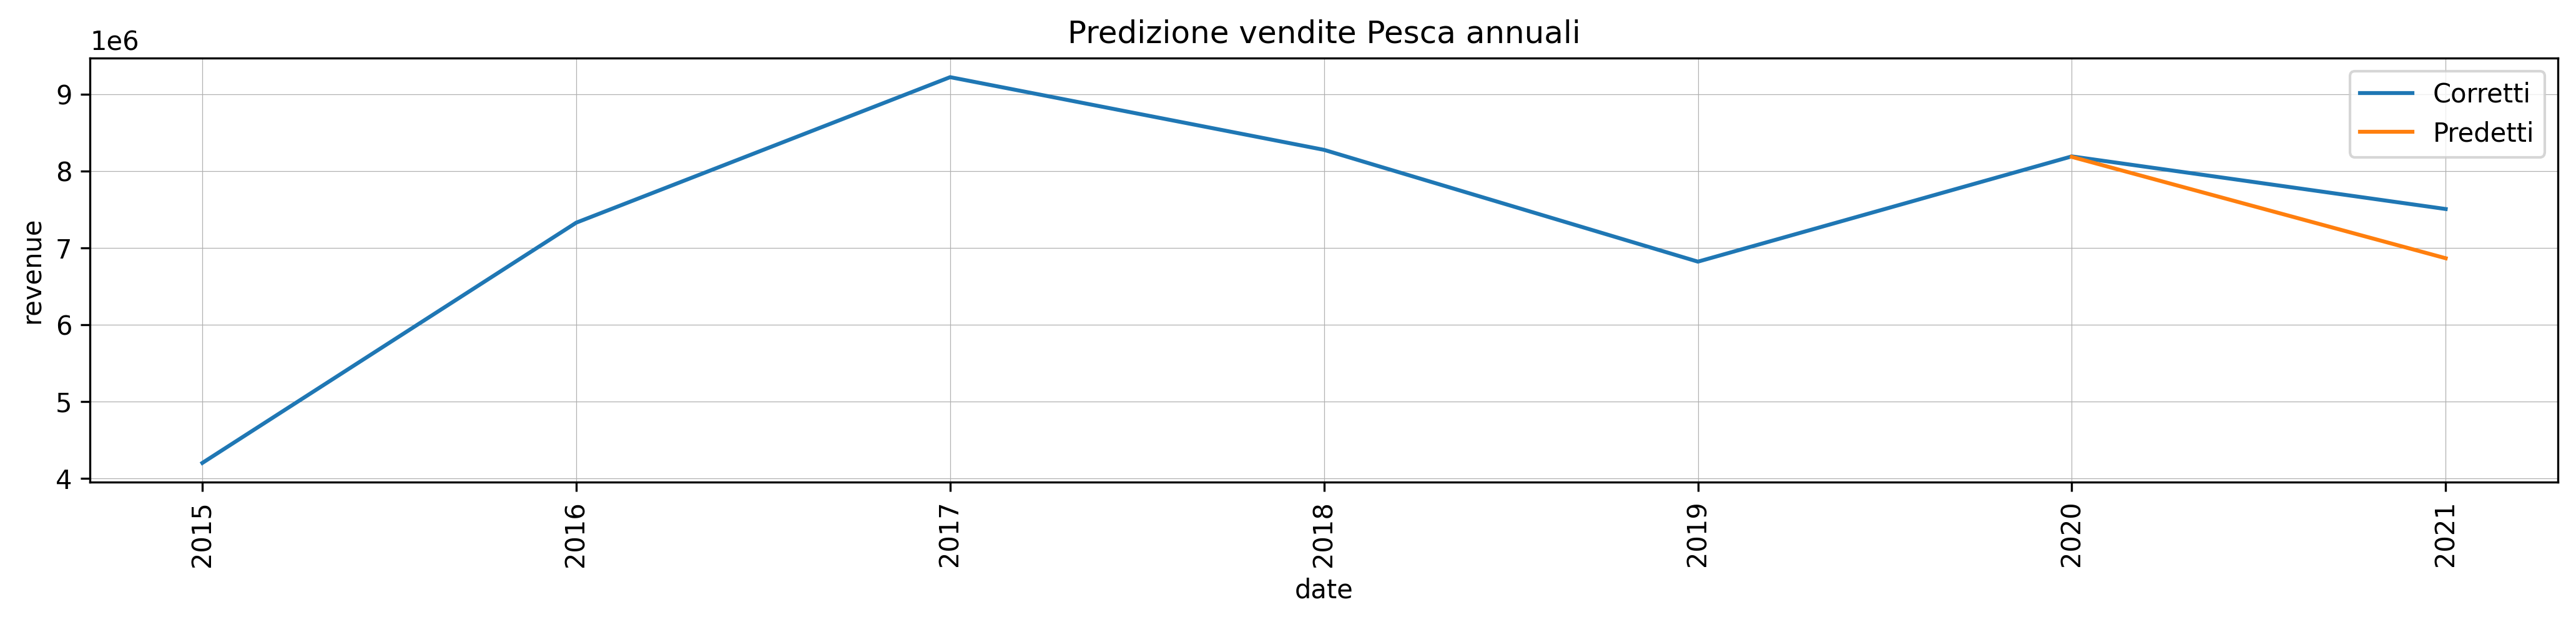

In [34]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=ds_pesca, x= "year", y='revenue', label= "Corretti")     
sns.lineplot(data=pesca_evalutation_ds, x='year', y='predictions', palette= "red", label= "Predetti") 

#x = pesca_evalutation_ds['year']  
#y = pesca_evalutation_ds['predictions']
#for i,j in zip(x,y):
#  plt.annotate(str(j),xy=(i,j))
#
#y1 = pesca_evalutation_ds['revenue']
#for i,j in zip(x,y1):
#  plt.annotate(str(j),xy=(i,j))
#  pesca_evalutation_ds

plt.title("Predizione vendite Pesca annuali")
plt.xlabel ("date")

plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

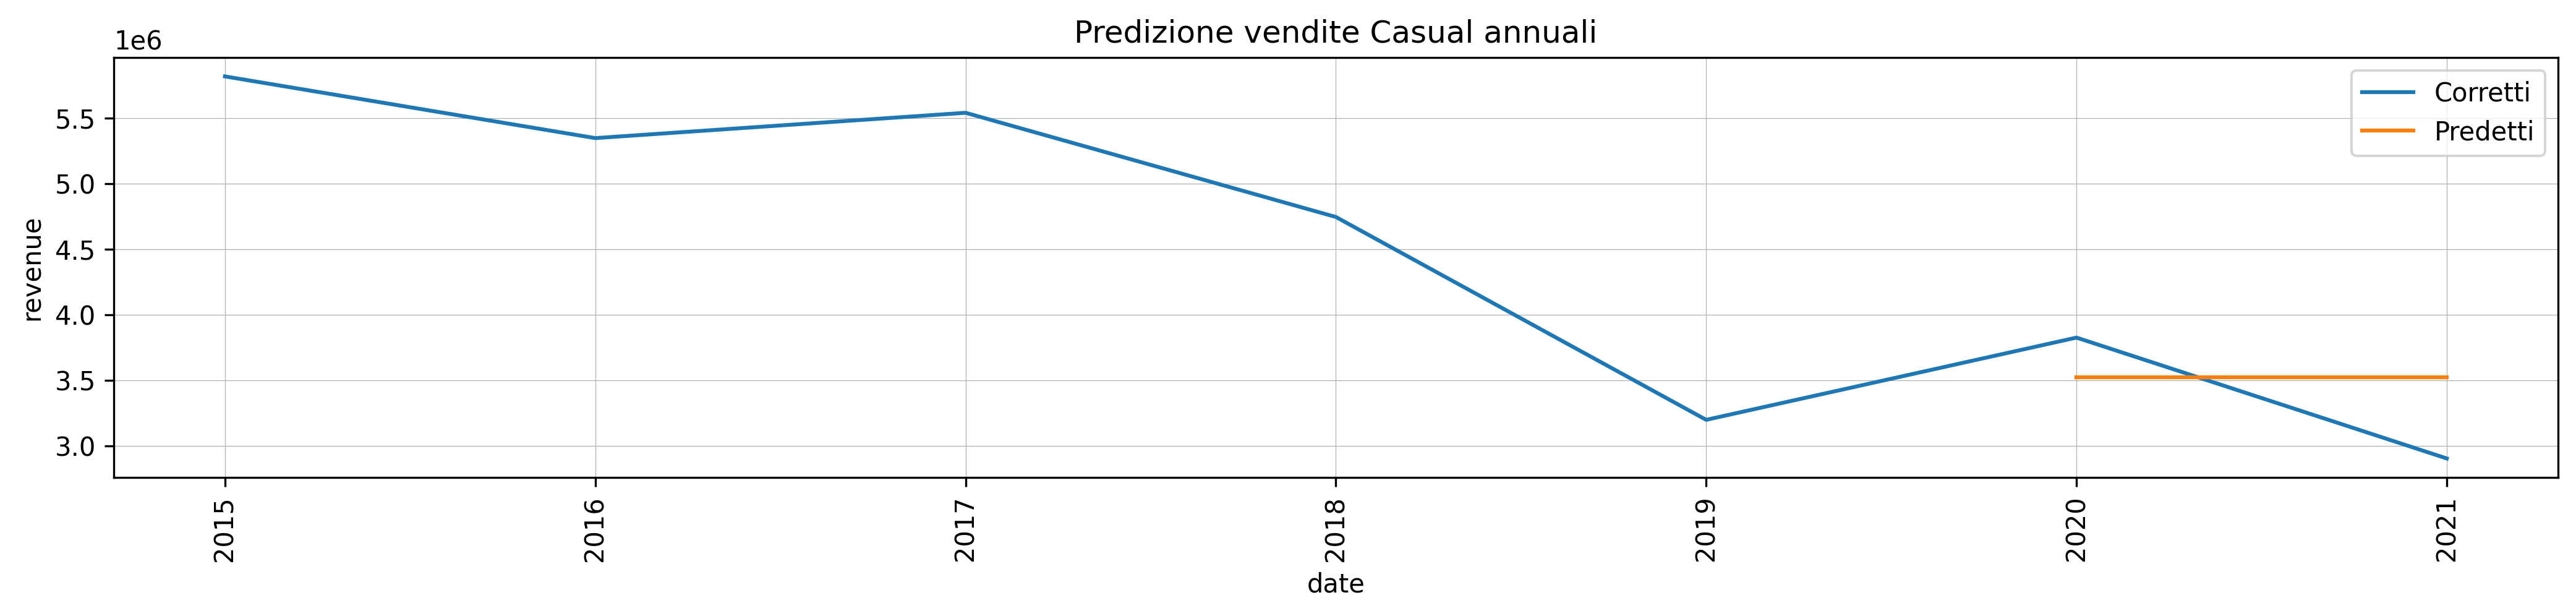

In [35]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=ds_casual, x= "year", y='revenue', label= "Corretti")     
sns.lineplot(data=casual_evalutation_ds, x='year', y='predictions', palette= "red", label= "Predetti") 

#x = casual_evalutation_ds['year']  
#y = casual_evalutation_ds['predictions']
#for i,j in zip(x,y):
#  plt.annotate(str(j),xy=(i,j))
#
#y1 = casual_evalutation_ds['revenue']
#for i,j in zip(x,y1):
#  plt.annotate(str(j),xy=(i,j))
#  casual_evalutation_ds

plt.title("Predizione vendite Casual annuali")
plt.xlabel ("date")

plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

In [23]:
calcio_evalutation_ds

,Unnamed: 0,year,revenue,totale_periodo_prec,predictions
0,6,2020,4764396.03,8278321.97,4770730.0
1,7,2021,3707615.13,4764396.03,4320212.0


In [24]:
pesca_evalutation_ds

,Unnamed: 0,year,revenue,totale_periodo_prec,predictions
0,6,2020,8190939.82,6821429.63,8184357.5
1,7,2021,7506147.47,8190939.82,6865867.5


In [25]:
casual_evalutation_ds

,Unnamed: 0,year,revenue,totale_periodo_prec,predictions
0,6,2020,3824241.17,3197252.84,3523587.75
1,7,2021,2902705.33,3824241.17,3523587.75


In [26]:
print('Calcio XgBoost Mean Absolute Error (MAE): ', np.mean(np.abs(calcio_evalutation_ds["revenue"] - calcio_evalutation_ds["predictions"])))

Calcio XgBoost Mean Absolute Error (MAE):  309465.4200000004


In [27]:
print('Pesca XgBoost Mean Absolute Error (MAE): ', np.mean(np.abs(pesca_evalutation_ds["revenue"] - pesca_evalutation_ds["predictions"])))

Pesca XgBoost Mean Absolute Error (MAE):  323431.145


In [28]:
print('Casual XgBoost Mean Absolute Error (MAE): ', np.mean(np.abs(casual_evalutation_ds["revenue"] - casual_evalutation_ds["predictions"])))

Casual XgBoost Mean Absolute Error (MAE):  460767.9199999999


In [29]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [30]:
print('Calcio XgBoost Mean Absolute Percentage Error (MAPE): ', mean_absolute_percentage_error(calcio_evalutation_ds["revenue"], calcio_evalutation_ds["predictions"]))

Calcio XgBoost Mean Absolute Percentage Error (MAPE):  8.327804983371417


In [31]:
print('Pesca XgBoost Mean Absolute Percentage Error (MAPE): ', mean_absolute_percentage_error(pesca_evalutation_ds["revenue"], pesca_evalutation_ds["predictions"]))

Pesca XgBoost Mean Absolute Percentage Error (MAPE):  4.3052177345221825


In [32]:
print('Casual XgBoost Mean Absolute Percentage Error (MAPE): ', mean_absolute_percentage_error(casual_evalutation_ds["revenue"], casual_evalutation_ds["predictions"]))

Casual XgBoost Mean Absolute Percentage Error (MAPE):  14.625782242844018


(Calcio migliore intorno ai 180)
(Pesca migliore intorno ai 420)
(Casual migliore intorno ai 150)


Senza l'anno 2022 nella predizione


* Calcio XgBoost Mean Absolute Error (MAE):  309465.427
* Pesca XgBoost Mean Absolute Error (MAE):  323431.15
* Casual XgBoost Mean Absolute Error (MAE):  460767.92


* Calcio XgBoost Mean Absolute Percentage Error (MAPE):  8.33 %
* Pesca XgBoost Mean Absolute Percentage Error (MAPE):  4.31 %
* Casual XgBoost Mean Absolute Percentage Error (MAPE):  14.63 %